# FinanceFormer Transformer based Model for Investment Portfolio-Optimization

In the field of quantitative finance, alpha and beta investment strategies are the two most common types of investment strategies. Imagine you are an investment fund manager and your current portfolio contains 300 stocks. You are faced with a decision-making scenario where you need to determine which of these 300 stocks are high-quality (with high relative returns), which you will continue to hold or increase your holdings in, and which of the lower relative return stocks you may consider selling.

So, how do you make these predictions? Often, we can construct some leading indicators (or features), which can be considered as advance signals that the future stock prices will change, and are the basis for our future predictions. In this dataset, there are a total of 300 anonymous signals (features), and the problem to be predicted is the relative return size of different investment targets (investment_id) on each day (time_id). The evaluation metric is different from traditional regression prediction metrics, and uses Pearson correlation coefficient, where a higher value indicates a more accurate prediction of the relative return size of all investment targets in the entire investment portfolio.

Before delving further, let's explore the data a bit.

In [ ]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
%matplotlib inline

import os

import gc
from pathlib import Path
from tqdm import tqdm

# EDA

In [ ]:
train = pd.read_parquet("/content/data.parquet")

In [ ]:
train.head()

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0_10,0,10,-0.260731,-1.863797,0.113691,1.573864,-0.598433,-0.569936,0.398784,...,0.821560,0.912726,0.476309,-1.220772,0.941183,-0.434315,1.296864,0.171329,1.051288,-0.745335
1,0_12,0,12,-0.469207,0.408954,-0.765238,0.261430,-0.591895,-0.037260,0.668721,...,0.821560,-1.095620,-0.864354,-1.220772,-1.060166,-0.300218,1.296864,-0.779556,0.274961,-0.182520
2,0_29,0,29,-0.867619,-1.342943,-2.271974,0.249359,-0.581436,-0.504053,-0.827677,...,1.813485,-1.095620,0.316884,-1.220772,-1.060166,-0.483199,0.104928,-0.792373,-0.071179,-0.573232
3,0_31,0,31,-0.748334,-0.359627,0.239253,0.196136,-0.540737,-0.260257,0.517623,...,0.870077,-1.095620,0.831767,-1.220772,0.941183,-0.250981,-1.087009,-1.088629,-1.584323,0.077664
4,0_34,0,34,-0.381478,0.669916,-0.890799,0.342481,-0.594042,-0.367400,-0.236299,...,-0.170365,0.912726,-0.346847,-1.220772,0.941183,-0.356439,1.296864,-0.218136,0.793085,-0.420624


In [ ]:
train.shape

(566236, 304)

In [ ]:
# Number of investment targets
train.investment_id.nunique()

488

In [ ]:
# Time span of investment

train.groupby("investment_id")['time_id'].agg(['min', 'max', 'count']).describe()

,min,max,count
count,488.0,488.0,488.000000
mean,0.0,1219.0,1160.319672
std,0.0,0.0,28.063149
min,0.0,1219.0,1101.000000
25%,0.0,1219.0,1139.000000
50%,0.0,1219.0,1164.000000
75%,0.0,1219.0,1182.000000
max,0.0,1219.0,1211.000000


The timestamp ranges from 0 to 1219, but there are some missing values, which may be non-trading days.

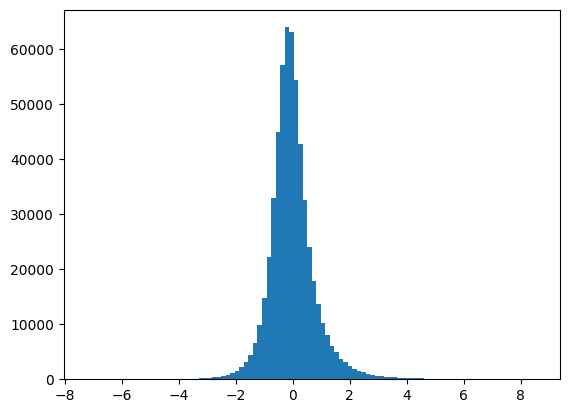

In [ ]:
_ = plt.hist(train.target, 100)

The target distribution is very normal (i.e., normally distributed)

In [ ]:
feat_cols = [f'f_{i}' for i in range(300)]

train[feat_cols].mean().describe()

count    300.000000
mean      -0.043781
std        0.150849
min       -0.503176
25%       -0.164330
50%       -0.010530
75%        0.021321
max        0.477960
dtype: float64

 The mean of the features is distributed between -0.5 and 0.5. Some processing may have been done before, so let's check the min/max values.

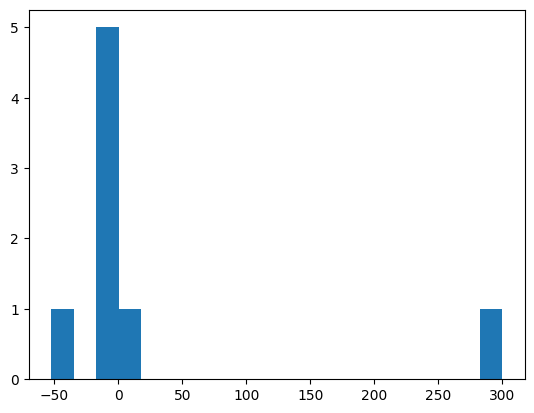

In [ ]:

_ = plt.hist(train[feat_cols].min().describe(), 20)

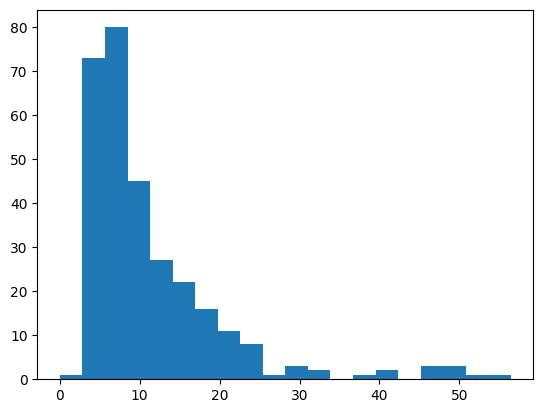

In [ ]:
_ = plt.hist(train[feat_cols].max(), 20)

In [ ]:
# The distribution of min/max values is also relatively concentrated

View the distribution of 16 features randomly.

Create a 4x4 grid of subplots with a total size of 16x16. For each subplot, randomly select a feature from the first 300 features (the feature names start with 'f_'), plot its histogram using 100 bins, and set the subplot title to the name of the feature. The purpose of this code may be to explore the distributions of some features in the "train" dataset and gain insights into their characteristic

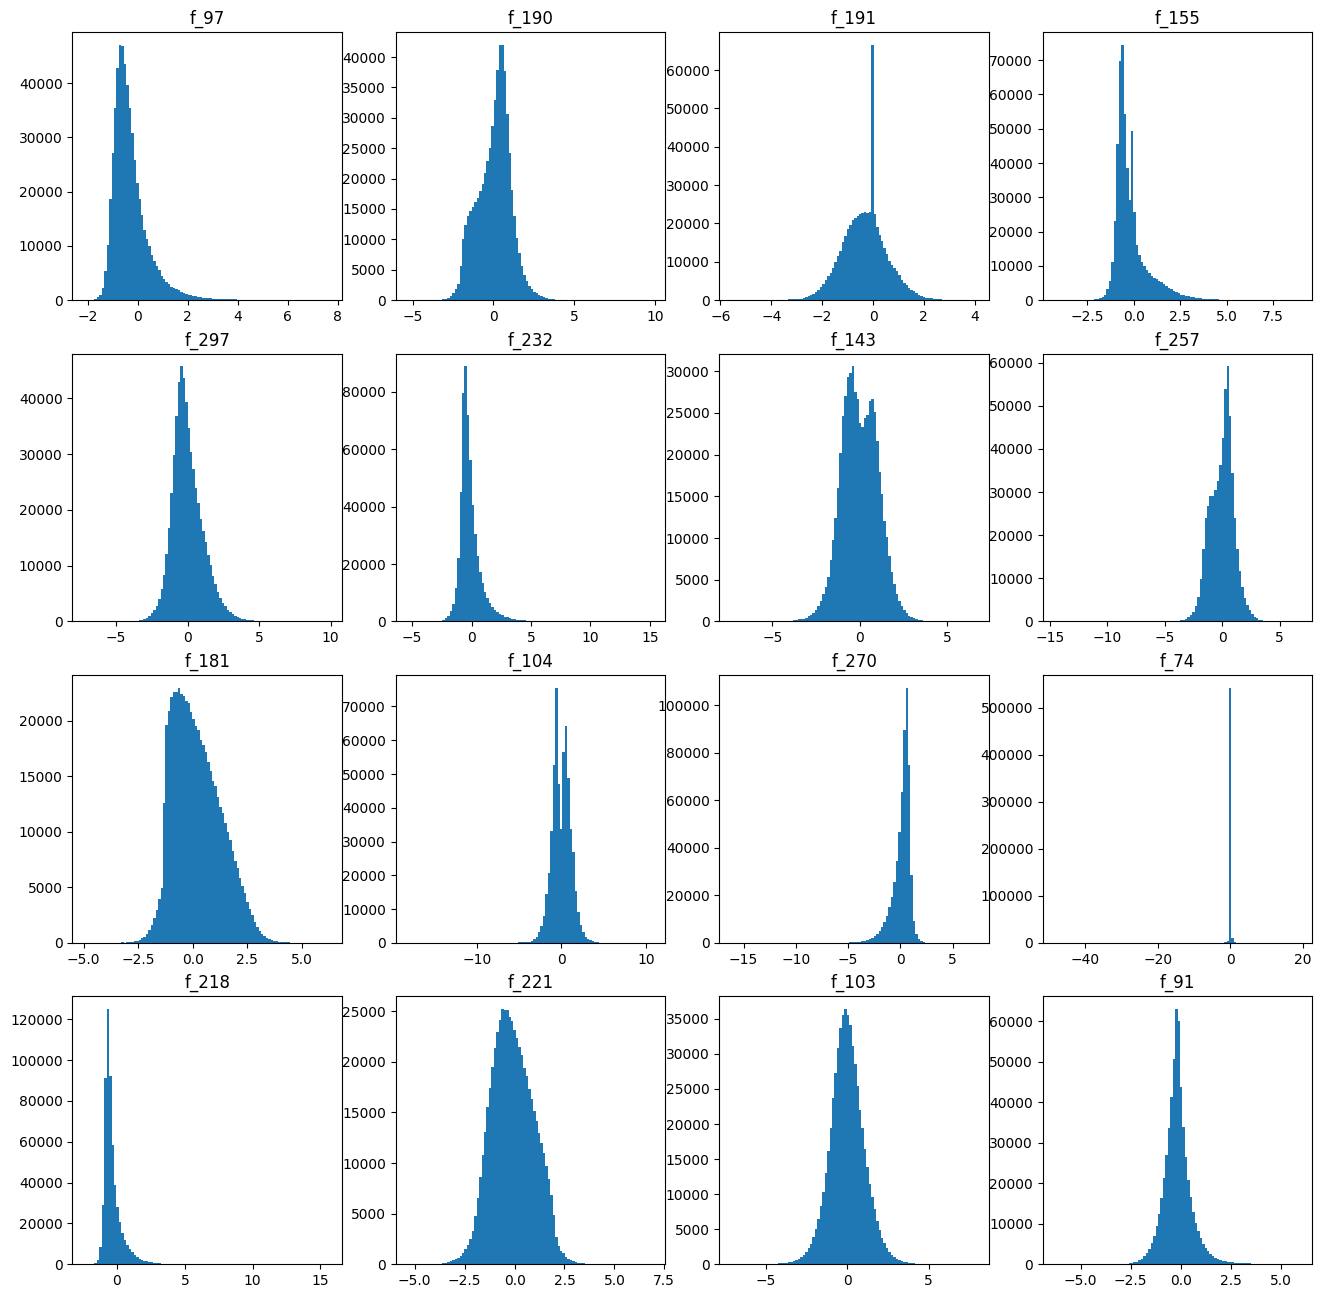

In [ ]:
f, ax = plt.subplots(4,4,figsize=(16,16))

for i in range(4):
    for j in range(4):
        col = f'f_{np.random.randint(0, 300)}'
        ax[i][j].hist(train[col], 100)
        ax[i][j].set_title(col)

# FinanceFormer Trainsformer

The features are the 300 features of each investment at each time step, and the target is the relative return of the investment.

We have four modeling paradigms:

Considering the current features of a single investment at a time, the input information is the 300 features. This modeling method is simple, but since our target is essentially a ranking, it is difficult to predict the ranking of returns if only considering a single investment.

The model considers all investments at the current time step while predicting the target. Transformer is very suitable for this scenario, as self-attention will calculate the relationships between all investments. Since there is no time series problem, position embedding is not needed.

The model considers the historical feature sequence of each investment, which models the trend and volatility of the investment. RNN/Seq2Seq/Transformer can be used for this modeling method.

Considering both time series and investments simultaneously, a feasible modeling method is to encode each investment input with an RNN, and then use the approach in method 2 for modeling.

Here, we will use method 2 for modeling. First, we will analyze the data briefly.

# Data Preparation
First, we fill in the missing time for investment_id.

In [ ]:
import itertools

In [ ]:
train_missing = set(itertools.product(train.investment_id.unique(), train.time_id.unique())) - \
set([tuple(l) for l in train[['investment_id', 'time_id']].values.tolist()])

In [ ]:
len(train_missing)

24732

In [ ]:
miss_train = pd.DataFrame([list(l) for l in train_missing], columns=['investment_id', 'time_id'])
miss_train['row_id'] = miss_train['time_id'].astype(str) + "_" + miss_train['investment_id'].astype(str)

In [ ]:
train = pd.concat([train, miss_train], axis=0, ignore_index=True).sort_values(['time_id', 'investment_id'])

In [ ]:
train.head()

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0_10,0,10,-0.260731,-1.863797,0.113691,1.573864,-0.598433,-0.569936,0.398784,...,0.821560,0.912726,0.476309,-1.220772,0.941183,-0.434315,1.296864,0.171329,1.051288,-0.745335
1,0_12,0,12,-0.469207,0.408954,-0.765238,0.261430,-0.591895,-0.037260,0.668721,...,0.821560,-1.095620,-0.864354,-1.220772,-1.060166,-0.300218,1.296864,-0.779556,0.274961,-0.182520
2,0_29,0,29,-0.867619,-1.342943,-2.271974,0.249359,-0.581436,-0.504053,-0.827677,...,1.813485,-1.095620,0.316884,-1.220772,-1.060166,-0.483199,0.104928,-0.792373,-0.071179,-0.573232
3,0_31,0,31,-0.748334,-0.359627,0.239253,0.196136,-0.540737,-0.260257,0.517623,...,0.870077,-1.095620,0.831767,-1.220772,0.941183,-0.250981,-1.087009,-1.088629,-1.584323,0.077664
4,0_34,0,34,-0.381478,0.669916,-0.890799,0.342481,-0.594042,-0.367400,-0.236299,...,-0.170365,0.912726,-0.346847,-1.220772,0.941183,-0.356439,1.296864,-0.218136,0.793085,-0.420624


In [ ]:
# Create a mask column, where 0 indicates padding samples and 1 indicates real samples

train['mask'] = 1-train['f_0'].isnull().astype(int)
train['target'] = train['target'].fillna(-1)
train.fillna(0., inplace=True)

In [ ]:
train.head()

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299,mask
0,0_10,0,10,-0.260731,-1.863797,0.113691,1.573864,-0.598433,-0.569936,0.398784,...,0.912726,0.476309,-1.220772,0.941183,-0.434315,1.296864,0.171329,1.051288,-0.745335,1
1,0_12,0,12,-0.469207,0.408954,-0.765238,0.261430,-0.591895,-0.037260,0.668721,...,-1.095620,-0.864354,-1.220772,-1.060166,-0.300218,1.296864,-0.779556,0.274961,-0.182520,1
2,0_29,0,29,-0.867619,-1.342943,-2.271974,0.249359,-0.581436,-0.504053,-0.827677,...,-1.095620,0.316884,-1.220772,-1.060166,-0.483199,0.104928,-0.792373,-0.071179,-0.573232,1
3,0_31,0,31,-0.748334,-0.359627,0.239253,0.196136,-0.540737,-0.260257,0.517623,...,-1.095620,0.831767,-1.220772,0.941183,-0.250981,-1.087009,-1.088629,-1.584323,0.077664,1
4,0_34,0,34,-0.381478,0.669916,-0.890799,0.342481,-0.594042,-0.367400,-0.236299,...,0.912726,-0.346847,-1.220772,0.941183,-0.356439,1.296864,-0.218136,0.793085,-0.420624,1


In [ ]:
#Check that the number of investment_id is consistent for each time period

train.groupby('time_id')['investment_id'].count().agg(['min', 'max'])

min    488
max    488
Name: investment_id, dtype: int64

In [ ]:
np.max(np.abs(train.iloc[:, 3:].values))

56.43994140625

# Building the Dataset

In [ ]:
# The most important thing before modeling is to define the input data structure
FEATURE = [f'f_{i}' for i in range(300)]

class CustomDataSet(Dataset):
    
    def __init__(self, df):
        self.gp = df.groupby('time_id')
        self.time_id = df.time_id.unique()
    
    def __len__(self):
        return len(self.time_id)
    
    def __getitem__(self, item):
        df = self.gp.get_group(self.time_id[item])
        feat = df[FEATURE].values
        mask = df['mask'].values
        if 'target' in df.columns:
            target = df['target'].values
            return {"feat": feat, "mask": mask}, target
        return {"feat": feat, "mask": mask}

In [ ]:
# Check
train_ds = CustomDataSet(train)
print(train_ds[0])

del train_ds
import gc
gc.collect()

({'feat': array([[-1.863797  ,  0.11369129,  1.5738639 , ...,  0.17132935,
         1.0512877 , -0.7453346 ],
       [ 0.4089536 , -0.7652381 ,  0.2614297 , ..., -0.7795557 ,
         0.27496114, -0.18251964],
       [-1.3429427 , -2.2719738 ,  0.24935897, ..., -0.7923725 ,
        -0.07117853, -0.5732324 ],
       ...,
       [-0.02631418, -0.89079934, -0.02999546, ..., -0.14933178,
        -1.8906543 , -0.5310525 ],
       [-0.29672122,  0.11369123,  1.0313586 , ...,  1.3295879 ,
        -0.7686633 , -0.59047115],
       [ 0.6334183 ,  0.23925258, -1.7832236 , ...,  1.1301484 ,
         1.2856898 ,  1.3332078 ]], dtype=float32), 'mask': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

0

# Model
Since the investment_ids at the same time have no order meaning, we do not need to construct Position Embedding. However, it is important to note that we have filled in missing data, so we need to use Mask information when calculating Self-Attention to avoid the impact of filling data on our model. Additionally, we should not process the Label in the filling data when calculating Loss.

In [ ]:
class FinanceFormerModel(nn.Module):
    
    def __init__(self, input_size, num_layers, d_model, ffn_size, n_head):
        super().__init__()
        self.input_fc = nn.Linear(input_size, d_model)
        self.transformers = nn.Sequential(*[
            nn.TransformerEncoderLayer(d_model, n_head, ffn_size, batch_first=True) for i in range(num_layers)])
        self.head = nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.GELU(),
            nn.Linear(d_model//2, 1)
        )
        self.loss_fn = nn.MSELoss(reduce=False)
        
    def forward(self, feat, mask, label=None):
        feat = self.input_fc(feat.float())
        for layer in self.transformers:
            #Add residual connection.
            feat = layer(feat, src_key_padding_mask=mask.float()) * 0.9 + feat * 0.1  # residual connect
        pred = self.head(feat).squeeze()
        
        if label is not None:
            loss = self.loss_fn(label.float(), pred)
            loss = (loss * mask) / torch.sum(mask)
            return pred, loss
        return pred

# Training

In [ ]:
import gc
from pathlib import Path

import numpy as np
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import random

def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)


class AverageMeter(object):
    val = 0
    avg = 0
    sum = 0
    count = 0
    best = None

    """Computes and stores the average and current value"""
    def __init__(self, larger_is_better=False):
        self.larger_is_better = larger_is_better
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        if self.larger_is_better:
            self.best = -np.inf
        else:
            self.best = np.inf

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        if self.larger_is_better and (val > self.best):
            self.best = val
            return True
        elif (not self.larger_is_better) and (val < self.best):
            self.best = val
            return True
        else:
            return False


def to_device(d, device):
    if isinstance(d, dict):
        return {k: to_device(v, device) for k, v in d.items()}
    elif isinstance(d, torch.Tensor):
        return d.to(device)
    elif isinstance(d, list):
        return [to_device(i, device) for i in d]
    else:
        raise ValueError


class TrainerConfig:
    max_epochs = 8
    batch_size = 32
    grad_norm_clip = None
    # Data Loader
    num_workers = 8
    collate_fn = None
    # Device
    device = "cpu"
    gpu_ids = None
    save_last = False
    # random
    seed = 42

    def __init__(self, save_path, **kwargs):
        self.save_path = save_path
        for k, v in kwargs.items():
            setattr(self, k, v)


class Trainer:

    def __init__(self, train_config, model, optimizer, train_dataset,
                 test_dataset=None, metric_fn=None, metric_larger_better=True, lr_scheduler=None, collate_fn=None):
        seed_everything(train_config.seed)
        self.model = model
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.config = train_config
        self.metric_fn = metric_fn
        self.metric_larger_better = metric_larger_better
        self.collate_fn = collate_fn
        # take over whatever gpus are on the system
        self.device = self.config.device
        if self.config.gpu_ids is not None:
            self.model = torch.nn.DataParallel(self.model, device_ids=self.config.gpu_ids).to(self.device)
        else:
            self.model.to(self.device)
    def save_checkpoint(self, oof, last=False):
        # DataParallel wrappers keep raw model object in .module attribute
        Path(self.config.save_path).parent.mkdir(parents=True, exist_ok=True)
        raw_model = self.model.module if hasattr(self.model, "module") else self.model
        save_path = self.config.save_path
        if last:
            save_path = self.config.save_path + ".last"
        print(f"saved in {save_path}")
        torch.save({'checkpoint': raw_model.state_dict(), 'oof': oof}, save_path)

    @torch.no_grad()
    def valid_epoch(self, loader):
        model, config = self.model, self.config
        model.eval()
        losses = AverageMeter()
        pbar = enumerate(loader)
        score = None
        preds, labels = [], []
        for it, (x, y) in pbar:
            x = to_device(x, self.device)
            y = to_device(y, self.device)
            # forward the model
            logit, loss = model(**x, label=y)
            loss = loss.mean()  # collapse all losses if they are scattered on multiple gpus
            losses.update(loss.item())
            preds.append(logit.cpu().numpy())
            labels.append(y.cpu().numpy())
            del x; del y; gc.collect()
        preds = np.concatenate(preds, axis=0)
        labels = np.concatenate(labels, axis=0)
        if self.metric_fn is not None:
            score = self.metric_fn(labels, preds)
        return losses.avg, preds, score

    def train_epoch(self, loader, num_epoch):
        model, optimizer, lr_scheduler, config = self.model, self.optimizer, self.lr_scheduler, self.config
        model.train()
        score = None
        losses = AverageMeter()
        pbar = tqdm(enumerate(loader), total=len(loader))
        preds = []
        labels = []

        for it, (x, y) in pbar:
            # place data on the correct device
            x = to_device(x, self.device)
            y = to_device(y, self.device)

            # forward the model
            logit, loss = model(**x, label=y)
            loss = loss.mean()  # collapse all losses if they are scattered on multiple gpus

            # backprop and update the parameters
            model.zero_grad()
            loss.backward()
            if self.config.grad_norm_clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_norm_clip)
            optimizer.step()

            # record
            loss = loss.item()
            losses.update(loss)

            preds.append(logit.detach().cpu().numpy())
            labels.append(y.cpu().numpy())

            # decay the learning rate based on our progress
            if lr_scheduler is not None:
                lr_scheduler.step(num_epoch+it/len(loader))
            lr = []
            for param_group in optimizer.param_groups:
                lr.append(param_group['lr'])
            lr = np.mean(lr)

            # report progress
            pbar.set_description(f"train loss {loss:.4f} lr {lr:.6f}")

        labels = np.concatenate(labels, axis=0)
        preds = np.concatenate(preds, axis=0)
        if self.metric_fn is not None:
            score = self.metric_fn(labels, preds)
        return losses.avg, score

    def fit(self):
        config = self.config
        scores = AverageMeter(self.metric_larger_better)

        train_loader = DataLoader(
            self.train_dataset,
            shuffle=True,
            pin_memory=True,
            batch_size=config.batch_size,
            num_workers=config.num_workers,
            collate_fn=self.collate_fn
        )

        if self.test_dataset is not None:
            test_loader = DataLoader(
                self.test_dataset,
                shuffle=True,
                pin_memory=True,
                batch_size=config.batch_size,
                num_workers=config.num_workers,
                collate_fn=self.collate_fn
            )

        for epoch in range(config.max_epochs):
            trn_loss, trn_score = self.train_epoch(train_loader, epoch)
            info = f"Epoch {epoch + 1} train loss {trn_loss:.4f}"
            if self.metric_fn is not None:
                info += f" score {trn_score:.4f}"
            if self.test_dataset is not None:
                val_loss, val_preds, val_score = self.valid_epoch(test_loader)
                info += f" val loss {val_loss:.4f}"
                if self.metric_fn is not None:
                    info += f" score {val_score: .4f}"
                good_model = scores.update(val_score)
                if good_model:
                    self.save_checkpoint(val_preds, False)
            print(info)
            # supports early stopping based on the test loss, or just save always if no test set is provided
        if self.config.save_last:
            self.save_checkpoint(None if self.test_dataset is None else val_preds, True)

    @torch.no_grad()
    def predict(self, dataset):
        self.model.eval()
        loader = DataLoader(
            dataset,
            shuffle=True,
            pin_memory=True,
            batch_size=self.config.batch_size,
            num_workers=self.config.num_workers,
            collate_fn=self.collate_fn
        )
        preds = []
        for x in loader:
            x = to_device(x, self.device)
            logit = self.model(**x)
            preds.append(logit.cpu().numpy())
        preds = np.concatenate(preds, axis=0)
        return preds


# Data splitting

In [ ]:
# Select the last 100 time_id as the validation set.
time_ids = train.time_id.unique()
train_time_ids = time_ids[:-100]
val_time_ids = time_ids[-100:]

train_ds = CustomDataSet(train[train.time_id.isin(train_time_ids)])
val_ds = CustomDataSet(train[train.time_id.isin(val_time_ids)])

# Evaluation function

In [ ]:
from scipy import stats
def pearson_score(labels, preds):
    # Check for NaN and Inf values in preds
    if np.isnan(preds).any() or np.isinf(preds).any():
        # Replace NaN and Inf values with 0
        preds = np.nan_to_num(preds)
        
    # For each sample (the return of each investment product under a certain time_id), calculate the current time_id Pearson score and then calculate the average.
    return np.mean([stats.pearsonr(l, p)[0] for l, p in zip(labels, preds)])


# Model

In [ ]:
model = FinanceFormerModel(input_size=300, num_layers=3, d_model=512, ffn_size=1024, n_head=8)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

config = TrainerConfig(save_path="./test_model.bin", batch_size=32, max_epochs=10)
trainer = Trainer(config, model, optimizer, train_dataset=train_ds, test_dataset=val_ds, 
                  metric_fn=pearson_score, metric_larger_better=True)
trainer.fit()

# Summary of Modeling Ideas:

Why Transformer: Utilize the Self-Attention feature to consider all pairwise combinations of any investment products in the model, making the overall ranking more stable.


There is no order relationship between investment products, so Position Embedding is not added here.


Residual connections are added between Transformer Blocks to improve model convergence speed and accuracy.


Fill in the missing trading data for some investment products, and use Mask Attention on the filled data so that we can batch process the data and avoid interference from the filled data on the model's performance.



# Optimization Ideas:

Try different model structures or training parameters.


Try using RNN/LSTM or other sequence models to encode each investment_id sequence and then input it to Investment-Wise-Transformer.


Use other machine learning or deep learning models for modeling and model fusion.